In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


def generate_data(num):
    num_a = num // 2
    num_b = num - num_a
    a = np.random.randn(num_a, 2)
    b = np.random.randn(num_b, 2)
    a[:, 0] = 0.2 * a[:, 0] + 0.7
    b[:, 0] = 0.2 * b[:, 0] - 0.7
    data = np.concatenate([a, b], axis=0)
    theta = np.random.rand()
    mat = [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    mat = np.array(mat).transpose()
    data = data @ mat
    data += [1., -1.]
    return data

def normalize_transform(x):
    mean = x.mean(axis=0)
    x = x - mean
    cov = x.transpose() @ x / (len(x) - 1.)
    eig_val, eig_vec = np.linalg.eig(cov)
    return [mean, eig_val, eig_vec]

def to_model_space(x_real, params):
    mean, eig_val, eig_vec = params
    return (x_real - mean) @ eig_vec @ np.diag(np.power(eig_val, -0.5)) @ eig_vec.transpose()

def to_data_space(x_model, params):
    mean, eig_val, eig_vec = params
    return (x_model @ eig_vec @ np.diag(np.power(eig_val, 0.5)) @ eig_vec.transpose()) + mean

def normality(x):
    g = x.cosh().log().mean().pow(2.)
    # g += x.pow(2.).mul(-0.5).exp().mean().pow(2.)
    return - g

In [27]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.randn(2, 1))

    def forward(self, x):
        self.normalize()
        return x @ self.w

    def normalize(self):
        self.w.data /= self.w.data.pow(2).sum(dim=0, keepdim=True).pow(0.5)

    def axis(self):
        self.normalize()
        axis = self.w.data.numpy().transpose()
        return axis

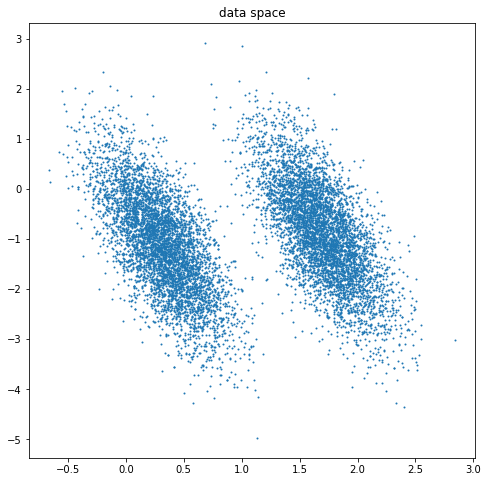

In [74]:
x_real = generate_data(10000)
plt.figure(figsize=(8,8))

plt.scatter(x_real[:, 0], x_real[:, 1], s=1)

plt.title('data space')
plt.show()


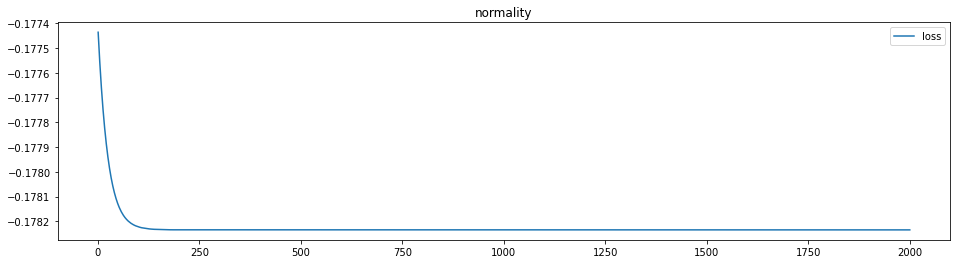

In [85]:
net = Net()
optimizer = torch.optim.SGD(net.parameters(), 1e-1)
avg_loss = []
for ep in range(2000):
    optimizer.zero_grad()
    y = net(torch.FloatTensor(xw))
    loss = normality(y)
    loss.backward()
    optimizer.step()
    avg_loss.append(loss.item())

plt.figure(figsize=(16, 4))
plt.title('normality')
plt.plot(range(1, 1 + len(avg_loss)), avg_loss, label='loss')
plt.legend()
plt.show()

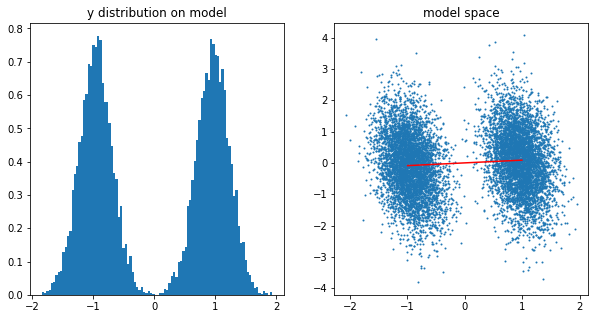

In [86]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,2,1)
axis = net.axis()
y = xw @ axis.transpose()

ax.hist(y[:, 0], bins=100, density=True)
ax.set_title('y distribution on model')

ax = fig.add_subplot(1,2,2)
ax.scatter(xw[:, 0], xw[:, 1], s=1)
ax.plot([-axis[0][0], axis[0][0]], [-axis[0][1], axis[0][1]], c='#FF0000')
ax.set_title('model space')
plt.show()

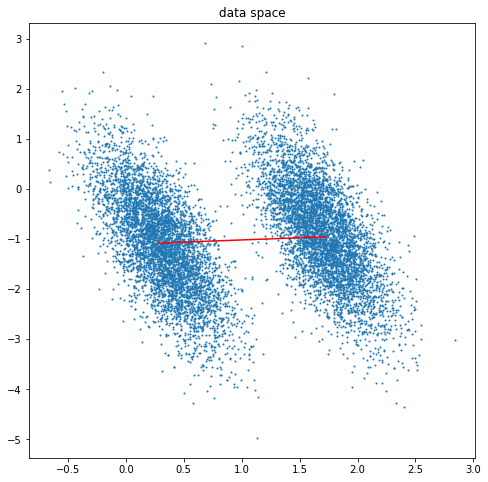

In [87]:
plt.figure(figsize=(8,8))

plt.scatter(x_real[:, 0], x_real[:, 1], s=1)

neg_point = to_data_space(-axis, transform)[0]
pos_point = to_data_space(axis, transform)[0]
plt.title('data space')
plt.plot([neg_point[0], pos_point[0]], [neg_point[1], pos_point[1]], c='#FF0000')
plt.show()